## Data Exploration and EDA

/var/folders/_w/ms1g9gts2bl_shfc5qfpp7x40000gn/T/ipykernel_4049/2602157900.py:101: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts = pd.to_datetime(
/var/folders/_w/ms1g9gts2bl_shfc5qfpp7x40000gn/T/ipykernel_4049/2602157900.py:101: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(
/var/folders/_w/ms1g9gts2bl_shfc5qfpp7x40000gn/T/ipykernel_4049/2602157900.py:105: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argum

✅ Successfully created unified dataset. Saved: ../data/merged_cleaned_timeseries_volume_hourly.csv
Rows: 6,930  Span: 2025-01-01 01:00:00 → 2025-10-17 22:00:00
✅ Successfully loaded 6930 hourly observations for EDA.
Saved: EDA_1_Volume_Temporal_Patterns.png
Saved: EDA_2_Volume_vs_Precipitation.png
Saved: EDA_3_Volume_Collision_Overlay.png


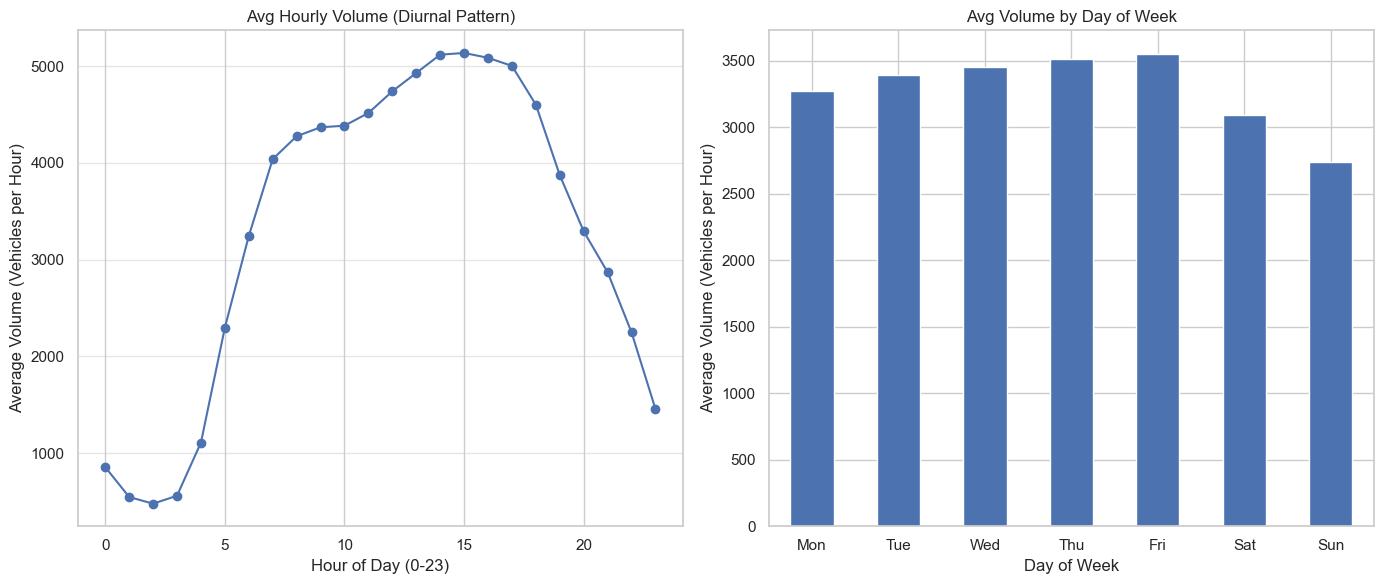

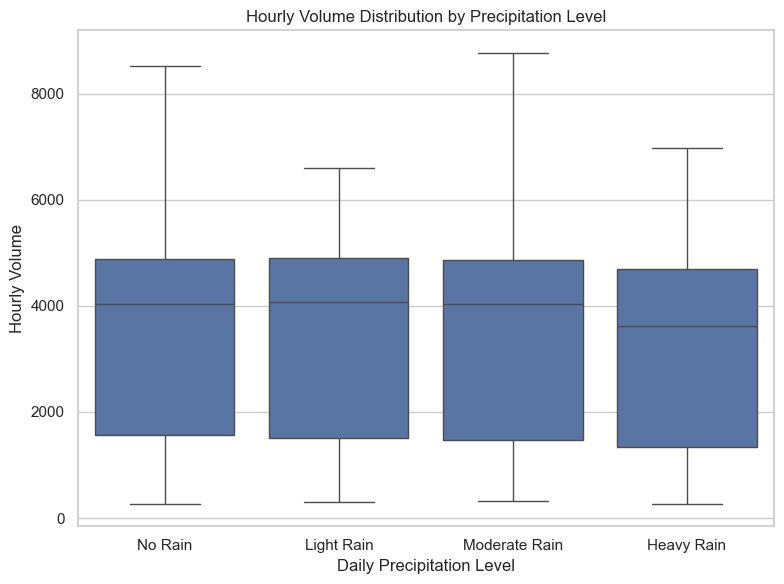

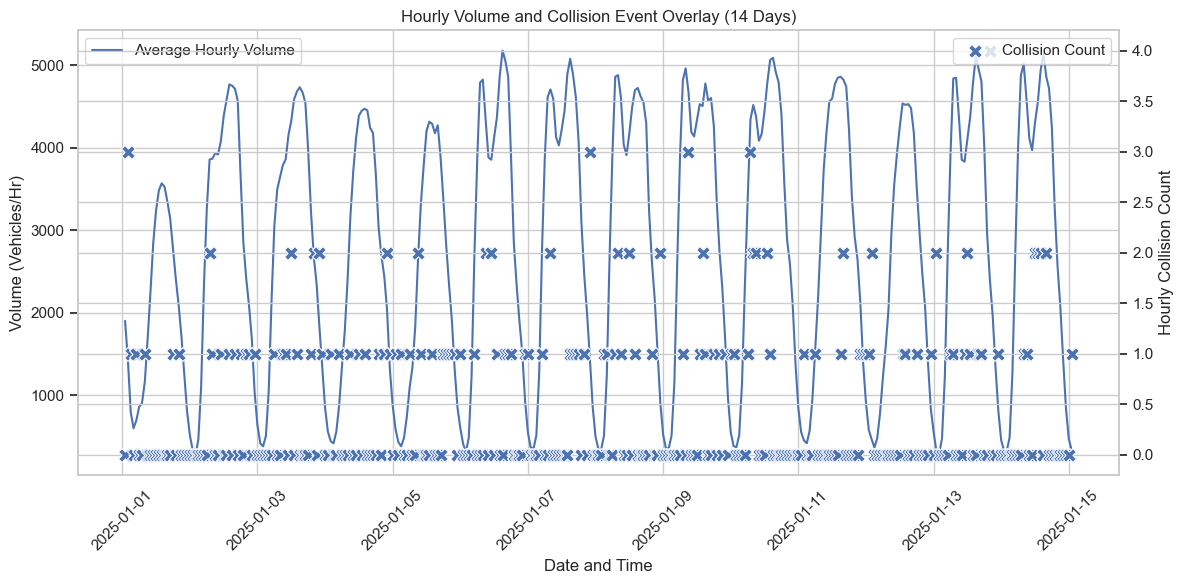

In [41]:
# --- Unified pipeline + EDA ---
import os, re, glob, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from openpyxl.utils import get_column_letter
from pathlib import Path

sns.set_theme(style="whitegrid")

# --- FILE CONFIGURATION ---
BASE_DIR = '..'
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_CSV = os.path.join(DATA_DIR, 'merged_cleaned_timeseries_volume_hourly.csv')
WEATHER_2024 = os.path.join(DATA_DIR, "King_County_Weather_2024.csv")
WEATHER_2025 = os.path.join(DATA_DIR, "King_County_Weather_2025.csv")
COLLISIONS   = os.path.join(DATA_DIR, "SDOT_Collisions_2024_2025.csv")

Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

# ---------------- Helpers for Excel parsing ----------------
def _extract_sensor_id(sheet_name: str, file_path: str) -> str:
    """Extract IDs like R017, R49R, S204, S533 from sheet or filename."""
    def grab(s):
        m = re.search(r'([RS]\d{2,3}[A-Z]?)', s.upper())
        return m.group(1) if m else None
    return grab(sheet_name) or grab(Path(file_path).name) or Path(file_path).stem

def _find_header_positions(ws, search_rows=60, search_cols=80):
    """Locate header row + DATE/TIME/VOLUME columns (1-based)."""
    targets = {"DATE": None, "TIME": None, "VOLUME": None}
    header_row = None
    for row in ws.iter_rows(min_row=1, max_row=search_rows, min_col=1, max_col=search_cols):
        for cell in row:
            v = cell.value
            if isinstance(v, str):
                u = v.strip().upper()
                if u in targets and targets[u] is None:
                    targets[u] = (cell.row, cell.column)
        if all(targets.values()):
            header_row = targets["DATE"][0]
            break
    if not header_row:
        return None
    return {
        "header_row": header_row,
        "date_col": targets["DATE"][1],
        "time_col": targets["TIME"][1],
        "volume_col": targets["VOLUME"][1],
    }

def _read_one_excel(path: str) -> pd.DataFrame:
    """Parse all sheets of one Excel file into a tidy DataFrame with Sensor/File/Sheet/DATE/TIME/VOLUME/timestamp."""
    try:
        wb = openpyxl.load_workbook(path, read_only=True, data_only=True)
    except Exception as e:
        print(f"[WARN] Cannot open {path}: {e}")
        return pd.DataFrame(columns=["Sensor_ID","Source_File","Sheet","DATE","TIME","VOLUME","timestamp"])

    frames = []
    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]
        pos = _find_header_positions(ws)
        if not pos:
            print(f"[WARN] {Path(path).name}::{sheet_name}: headers not found; skipping.")
            continue
        usecols = ",".join([get_column_letter(pos["date_col"]),
                            get_column_letter(pos["time_col"]),
                            get_column_letter(pos["volume_col"])])
        try:
            df = pd.read_excel(
                path,
                sheet_name=sheet_name,
                header=pos["header_row"] - 1,
                usecols=usecols,
                engine="openpyxl"
            )
        except Exception as e:
            print(f"[WARN] {Path(path).name}::{sheet_name}: read_excel failed: {e}")
            continue

        # Normalize column names
        df.columns = [str(c).strip().upper() for c in df.columns]
        ren = {}
        for c in df.columns:
            u = str(c).strip().upper()
            if u.startswith("DATE"): ren[c] = "DATE"
            elif u.startswith("TIME"): ren[c] = "TIME"
            elif "VOLUME" in u: ren[c] = "VOLUME"
        df = df.rename(columns=ren)

        if not {"DATE","TIME","VOLUME"}.issubset(df.columns):
            print(f"[WARN] {Path(path).name}::{sheet_name}: missing DATE/TIME/VOLUME; skipping.")
            continue

        df = df[["DATE","TIME","VOLUME"]].dropna(how="all")
        df["VOLUME"] = pd.to_numeric(df["VOLUME"], errors="coerce")

        ts = pd.to_datetime(
            df["DATE"].astype(str).str.strip() + " " + df["TIME"].astype(str).str.strip(),
            errors="coerce", infer_datetime_format=True
        )
        ts2 = pd.to_datetime(df["DATE"], errors="coerce", infer_datetime_format=True)
        df["timestamp"] = ts.fillna(ts2)

        df.insert(0, "Sheet", sheet_name)
        df.insert(0, "Source_File", Path(path).name)
        df.insert(0, "Sensor_ID", _extract_sensor_id(sheet_name, path))

        frames.append(df[["Sensor_ID","Source_File","Sheet","DATE","TIME","VOLUME","timestamp"]])

    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(
        columns=["Sensor_ID","Source_File","Sheet","DATE","TIME","VOLUME","timestamp"]
    )

# ---------------- 1) Load & Concatenate all traffic (from Excel, not CSV) ----------------
xlsx_files = glob.glob(os.path.join(DATA_DIR, "**", "HourlyDataByDirection_*.xlsx"), recursive=True)
if not xlsx_files:
    raise ValueError(f"No Excel files found under {DATA_DIR}. Expected pattern HourlyDataByDirection_*.xlsx")

traffic_frames = [_read_one_excel(fp) for fp in xlsx_files]
df_traffic_raw = pd.concat(traffic_frames, ignore_index=True)
if df_traffic_raw.empty:
    raise ValueError("Traffic data parsing failed: no rows loaded from Excel.")

# ---------------- 2) Fix Time Formatting and Create Master Hourly Index ----------------
# Make the mask for '24:00' BEFORE replacement
time_str = df_traffic_raw["TIME"].astype(str).str.strip()
mask_was_24h = time_str.eq("24:00")

# Replace 24:00 -> 00:00 for parsing
df_traffic_raw["TIME"] = time_str.str.replace("^24:00$", "00:00", regex=True)
df_traffic_raw["DATE"] = pd.to_datetime(df_traffic_raw["DATE"], errors="coerce")

# Build Time_Full and shift only originally-24:00 rows
df_traffic_raw["Time_Full"] = pd.to_datetime(
    df_traffic_raw["DATE"].dt.strftime("%Y-%m-%d") + " " + df_traffic_raw["TIME"].astype(str),
    errors="coerce"
)
df_traffic_raw.loc[mask_was_24h, "Time_Full"] = df_traffic_raw.loc[mask_was_24h, "Time_Full"] + pd.Timedelta(days=1)

df_traffic_base = (
    df_traffic_raw
    .assign(VOLUME=pd.to_numeric(df_traffic_raw["VOLUME"], errors="coerce"))
    .dropna(subset=["Time_Full","VOLUME"])
    .set_index("Time_Full")
    .sort_index()
)

# Aggregate across sensors per hour (mean). Change to sum() if you prefer totals.
df_hourly = df_traffic_base.groupby(level=0).mean(numeric_only=True)[["VOLUME"]]
# Ensure unique datetime index before reindex
df_hourly = df_hourly[~df_hourly.index.duplicated(keep="first")]

hourly_range = pd.date_range(start=df_hourly.index.min(), end=df_hourly.index.max(), freq="H")
df_clean = df_hourly.reindex(hourly_range)
df_clean["VOLUME"] = df_clean["VOLUME"].interpolate(method="linear", limit=12)

# ---------------- 3) Merge Daily Weather (dedup → hourly) ----------------
def _load_weather(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        print(f"[WARN] Weather file missing: {path}")
        return pd.DataFrame(columns=["DATE","TMAX","TMIN","PRCP","SNOW","TAVG"])
    df = pd.read_csv(path)
    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
    df = df.dropna(subset=["DATE"])
    for c in ("TMAX","TMIN","PRCP","SNOW","TAVG"):
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    # Prefer provided TAVG; else compute
    df["TAVG_Calc"] = df["TAVG"] if "TAVG" in df.columns else (df.get("TMAX") + df.get("TMIN")) / 2
    # Deduplicate by DATE (mean temps, sum precip/snow)
    df = (df.groupby("DATE", as_index=False)
            .agg(TAVG_Calc=("TAVG_Calc","mean"),
                 PRCP=("PRCP","sum"),
                 SNOW=("SNOW","sum")))
    return df

w24 = _load_weather(WEATHER_2024)
w25 = _load_weather(WEATHER_2025)
df_weather = pd.concat([w24, w25], ignore_index=True)

df_weather_daily = (df_weather
                    .sort_values("DATE")
                    .set_index("DATE")
                    [["TAVG_Calc","PRCP","SNOW"]])

# Make daily index continuous, then upsample to hourly
df_weather_daily = df_weather_daily[~df_weather_daily.index.duplicated(keep="first")]
daily_full_index = pd.date_range(df_weather_daily.index.min(), df_weather_daily.index.max(), freq="D")
df_weather_daily = df_weather_daily.reindex(daily_full_index).ffill()
df_weather_hourly = df_weather_daily.resample("H").ffill()

# Clip weather to traffic range
full_hourly_index = pd.date_range(df_clean.index.min(), df_clean.index.max(), freq="H")
df_weather_hourly = df_weather_hourly.reindex(full_hourly_index).ffill()

# Merge into traffic
df_final = df_clean.merge(df_weather_hourly, left_index=True, right_index=True, how="left")

# ---------------- 4) Merge Collision Data ----------------
def _load_collisions(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        print(f"[WARN] Collisions file missing: {path}")
        return pd.DataFrame(columns=["Time_Hr"])
    df = pd.read_csv(path, low_memory=False)
    ts_candidates = ["INCDTTM","INCIDENT_DATETIME","datetime","TIMESTAMP"]
    ts_col = next((c for c in ts_candidates if c in df.columns), None)
    if ts_col is None:
        print(f"[WARN] No usable timestamp col in collisions: {ts_candidates}")
        return pd.DataFrame(columns=["Time_Hr"])
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col])
    df["Time_Hr"] = df[ts_col].dt.round("H")  # or .dt.floor("H")
    return df

df_collisions = _load_collisions(COLLISIONS)
if not df_collisions.empty:
    collision_count = df_collisions.groupby("Time_Hr").size().rename("Collision_Count_Hr")
    df_final = df_final.merge(collision_count, left_index=True, right_index=True, how="left")
else:
    df_final["Collision_Count_Hr"] = 0

df_final["Collision_Count_Hr"] = df_final["Collision_Count_Hr"].fillna(0).astype(int)

# ---------------- 5) Feature Engineering ----------------
df_final["Target_Volume_1hr"] = df_final["VOLUME"].shift(-1)
df_final["Lag_Volume_1hr"]   = df_final["VOLUME"].shift(1)
df_final["Hour_of_Day"] = df_final.index.hour
df_final["Day_of_Week"] = df_final.index.dayofweek

df_final = df_final.dropna(subset=["VOLUME","Target_Volume_1hr","Lag_Volume_1hr"])

# Save final dataset
df_final.to_csv(OUTPUT_CSV, index=True)
print(f"✅ Successfully created unified dataset. Saved: {OUTPUT_CSV}")
print(f"Rows: {len(df_final):,}  Span: {df_final.index.min()} → {df_final.index.max()}")

# ------------------- EDA EXECUTION -------------------
# Load the just-saved file to ensure all columns are correct
df = pd.read_csv(OUTPUT_CSV, index_col=0, parse_dates=True)
print(f"✅ Successfully loaded {len(df)} hourly observations for EDA.")

VOLUME_COL = 'VOLUME'  # note: uppercase from pipeline

# VISUALIZATION 1: Diurnal and Weekly Volume Profile
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df_hourly_avg = df.groupby('Hour_of_Day')[VOLUME_COL].mean()
df_hourly_avg.plot(kind='line', marker='o')
plt.title('Avg Hourly Volume (Diurnal Pattern)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Volume (Vehicles per Hour)')
plt.grid(True, axis='y', alpha=0.5)

plt.subplot(1, 2, 2)
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df.groupby('Day_of_Week')[VOLUME_COL].mean().rename(index=day_map).plot(kind='bar')
plt.title('Avg Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Volume (Vehicles per Hour)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'EDA_1_Volume_Temporal_Patterns.png'))
print("Saved: EDA_1_Volume_Temporal_Patterns.png")

# VISUALIZATION 2: Volume vs. Weather (Precipitation)
plt.figure(figsize=(8, 6))
df['Precip_Group'] = pd.cut(df['PRCP'],
                            bins=[-0.01, 0.0, 0.1, 0.5, df['PRCP'].max()],
                            labels=['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain'],
                            right=True)
import seaborn as sns
sns.boxplot(x='Precip_Group', y=VOLUME_COL, data=df, showfliers=False)
plt.title('Hourly Volume Distribution by Precipitation Level')
plt.xlabel('Daily Precipitation Level')
plt.ylabel('Hourly Volume')

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'EDA_2_Volume_vs_Precipitation.png'))
print("Saved: EDA_2_Volume_vs_Precipitation.png")

# VISUALIZATION 3: Volume and Collision Events (Time Series Overlay)
plt.figure(figsize=(12, 6))
df_subset = df.loc[df.index.min() : df.index.min() + pd.Timedelta(days=14)]

ax1 = sns.lineplot(x=df_subset.index, y=VOLUME_COL, data=df_subset, label='Average Hourly Volume')
ax1.set_xlabel('Date and Time')
ax1.set_ylabel('Volume (Vehicles/Hr)')
ax1.tick_params(axis='y')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2 = sns.scatterplot(x=df_subset.index, y='Collision_Count_Hr', data=df_subset, marker='X', s=100, label='Collision Count')
ax2.set_ylabel('Hourly Collision Count')
ax2.tick_params(axis='y')

plt.title('Hourly Volume and Collision Event Overlay (14 Days)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'EDA_3_Volume_Collision_Overlay.png'))
print("Saved: EDA_3_Volume_Collision_Overlay.png")


In [42]:
import pandas as pd
# Define the file path using the assumed directory structure
FILE_PATH = '../data/merged_cleaned_timeseries_volume_hourly.csv'

# Load the file
df_diagnostic = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)

# Print all column names
print(df_diagnostic.columns.tolist())

['VOLUME', 'TAVG_Calc', 'PRCP', 'SNOW', 'Collision_Count_Hr', 'Target_Volume_1hr', 'Lag_Volume_1hr', 'Hour_of_Day', 'Day_of_Week']


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import os

# --- Configuration ---
FILE_PATH = '../data/merged_cleaned_timeseries_volume_hourly.csv'
OUTPUT_REPORT_DIR = '../data/'
# ---------------------

# Load the final cleaned data
df = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)

# 1. DEFINE FEATURES (X) AND TARGET (Y)
# Use the core time-based and lag features for the baseline model.
FEATURES = ['Lag_Volume_1hr', 'Hour_of_Day', 'Day_of_Week']
TARGET = 'Target_Volume_1hr'

# Drop rows with NaN in the target (already done in cleaning, but safe guard)
df_model = df.dropna(subset=[TARGET])

X = df_model[FEATURES]
y = df_model[TARGET]

# 2. TIME-SERIES SPLIT (Crucial)
# For time-series, you must train on the past and test on the future.
# We'll use the first 80% of data for training and the last 20% for testing.
split_point = int(len(df_model) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

print(f"Total Observations: {len(df_model):,}")
print(f"Training Set Size: {len(X_train):,}")
print(f"Testing Set Size: {len(X_test):,}")

# 3. TRAIN THE BASELINE MODEL (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# 4. PREDICT AND EVALUATE
y_pred = model.predict(X_test)

# Calculate Key Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_target = y_test.mean()

# 5. PRINT RESULTS
print("\n--- Baseline Model Results (Lagged Linear Regression) ---")
print(f"Mean Hourly Volume in Test Set: {mean_target:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} vehicles/hour")
print(f"Mean Absolute Error (MAE): {mae:.2f} vehicles/hour")
print("-" * 50)
print("MAE represents the average number of vehicles/hour the prediction is off by.")

# 6. SAVE RESULTS FOR COMPARISON
baseline_results = {
    'Model': 'Lagged Linear Regression',
    'RMSE': rmse,
    'MAE': mae,
    'Features': FEATURES
}
pd.DataFrame([baseline_results]).to_csv(os.path.join(OUTPUT_REPORT_DIR, 'baseline_results.csv'), index=False)
print(f"Baseline results saved to: {os.path.join(OUTPUT_REPORT_DIR, 'baseline_results.csv')}")

Total Observations: 6,930
Training Set Size: 5,544
Testing Set Size: 1,386

--- Baseline Model Results (Lagged Linear Regression) ---
Mean Hourly Volume in Test Set: 3654.87
Root Mean Squared Error (RMSE): 985.65 vehicles/hour
Mean Absolute Error (MAE): 752.42 vehicles/hour
--------------------------------------------------
MAE represents the average number of vehicles/hour the prediction is off by.
Baseline results saved to: ../data/baseline_results.csv
